**Problématique Métier **: Classement des Fleurs pour la Cosmétique et Parfumerie Yves Rocher.

**Description du Problème:**
Dans l’industrie de la parfumerie et des cosmétiques naturels Yves Rocher, l’identification précise des fleurs est cruciale pour :

-Assurer la qualité des extraits aromatiques (huiles essentielles, absolues)

-Éviter les erreurs de formulation (certaines fleurs ont des propriétés similaires mais des coûts très différents)

-Automatiser le contrôle qualité des matières premières florales reçues chez les fabricants

**Exemple concret :**

Un parfumeur reçoit un lot de "Lavande", mais certaines fleurs pourraient être des "Lavandins" (moins nobles). Une erreur d’identification entraînerait :

-Un parfum moins raffiné

-Un surcoût si la lavande vraie est remplacée par une variété moins chère

-Des risques d’allergie si des espèces non prévues sont utilisées


**Mon modèle Propose de** :

-Classer automatiquement les fleurs utilisées en parfumerie (ex : Lilly, Lotus, Tulip, Orchidée, et Sunflower.)

-Vérifier la conformité d'un lot (ex : "Ce bouquet est bien des Tulipes")



**DESCRIPTION:**

Dans la parfumerie et les cosmétiques, on utilise des fleurs de qualité pour créer des parfums et soins. Mais aujourd'hui, reconnaître les bonnes fleurs se fait encore à l'œil, ce qui prend du temps et peut causer des erreurs coûteuses.

Exemple concret :

Un parfumeur reçoit un lot marqué "rose de mai" (très précieuse)

En réalité, c'est une rose moins chère

Résultat : le parfum final n'a pas la bonne qualité

Notre solution utilise l'intelligence artificielle pour :

Reconnaître automatiquement les fleurs (rose, jasmin, lavande...)

Vérifier la qualité (détecter les fleurs abîmées ou impures)

Gagner du temps (plus besoin de tout vérifier manuellement)

Avantages :

✅ Moins d'erreurs dans les recettes

✅ Économies (on ne paye pas cher pour des fleurs moins nobles)

✅ Conformité aux règles du métier

Les données viennent de photos réelles de fleurs comme celles que j'ai récupérer depuis Kaggle, avec un focus sur les espèces utilisées en parfumerie. Le système peut être utilisé dès la réception des fleurs, avant leur transformation.


In [3]:
from google.colab import files
import zipfile
import os

# Téléverser le fichier zip
uploaded = files.upload()

# Extraire TOUTE l'arborescence
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('/content')  # Tout sera extrait dans /content/Projet Final1/

# Vérifier le contenu
print("Contenu du dossier :")


Saving flower_images.zip to flower_images (1).zip
Contenu du dossier :


Contenu extrait :
total 4
drwxr-xr-x 7 root root 4096 May 14 18:20 flower_images


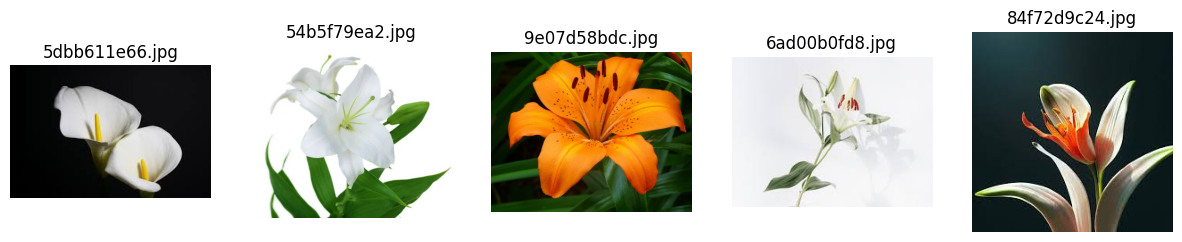

In [4]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

zip_path = '/content/flower_images.zip'
extract_path = '/content/flower_data'

# Extraction
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Vérification du contenu
print("Contenu extrait :")
!ls -l "{extract_path}"

# Afficher 5 échantillons
images = []
for root, _, files in os.walk(extract_path):
    for file in files[:5]:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            images.append(Image.open(img_path))
            if len(images) >= 5:
                break
    if len(images) >= 5:
        break

# Affichage
plt.figure(figsize=(15, 5))
for i, img in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(img.filename))
    plt.axis('off')
plt.show()

In [7]:
import os
import shutil
import random
import zipfile
from google.colab import files

# Configuration
UPLOADED_ZIP = '/content/flower_images.zip'
EXTRACTED_ROOT = '/content/extracted_data'
TARGET_ROOT = '/content/processed_data'
CLASSES = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

# Extraction du fichier ZIP
if not os.path.exists(EXTRACTED_ROOT):
    with zipfile.ZipFile(UPLOADED_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_ROOT)

# Détection automatique du bon chemin
def find_classes_path(base_path):

    class_paths = {}
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name in CLASSES:
                class_paths[dir_name] = os.path.join(root, dir_name)

    # Vérification que toutes les classes sont trouvées
    missing = set(CLASSES) - set(class_paths.keys())
    if missing:
        raise FileNotFoundError(f"Dossiers de classe manquants: {missing}")

    # Retourne le chemin parent commun
    return os.path.commonpath(list(class_paths.values()))

try:
    SOURCE_PATH = find_classes_path(EXTRACTED_ROOT)
    print(f"Chemin des classes détecté: {SOURCE_PATH}")
except Exception as e:
    print(f"Erreur: {e}")
    print("\nStructure actuelle des dossiers:")
    !find {EXTRACTED_ROOT} -type d | sort
    raise

# Vérification des images disponibles
print("\nNombre d'images par classe:")
for cls in CLASSES:
    cls_path = os.path.join(SOURCE_PATH, cls)
    num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{cls}: {num_images} images")

# Paramètres de traitement
SAMPLES_PER_CLASS = 300
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15

# Fonction pour créer la structure de sortie
def create_output_structure():
    for split in ['train', 'val', 'test']:
        for cls in CLASSES:
            os.makedirs(os.path.join(TARGET_ROOT, split, cls), exist_ok=True)

# Traitement principal
def process_images():
    create_output_structure()

    for cls in CLASSES:
        source_dir = os.path.join(SOURCE_PATH, cls)
        images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Sélection aléatoire
        selected = random.sample(images, min(SAMPLES_PER_CLASS, len(images)))
        random.shuffle(selected)

        # Calcul des séparations
        train_end = int(len(selected) * TRAIN_RATIO)
        val_end = train_end + int(len(selected) * VAL_RATIO)

        # Copie des fichiers
        for i, img in enumerate(selected):
            src = os.path.join(source_dir, img)
            if i < train_end:
                dest = os.path.join(TARGET_ROOT, 'train', cls, img)
            elif i < val_end:
                dest = os.path.join(TARGET_ROOT, 'val', cls, img)
            else:
                dest = os.path.join(TARGET_ROOT, 'test', cls, img)
            shutil.copy2(src, dest)

        print(f"{cls}: {len(selected)} images traitées (train: {train_end}, val: {val_end-train_end}, test: {len(selected)-val_end})")

# Exécution
if os.path.exists(TARGET_ROOT):
    shutil.rmtree(TARGET_ROOT)

process_images()

# Vérification finale
print("\nRésultat final:")
!find {TARGET_ROOT} -type f | wc -l

Chemin des classes détecté: /content/extracted_data/flower_images

Nombre d'images par classe:
Lilly: 999 images
Lotus: 1000 images
Orchid: 1000 images
Sunflower: 1000 images
Tulip: 1000 images
Lilly: 300 images traitées (train: 210, val: 45, test: 45)
Lotus: 300 images traitées (train: 210, val: 45, test: 45)
Orchid: 300 images traitées (train: 210, val: 45, test: 45)
Sunflower: 300 images traitées (train: 210, val: 45, test: 45)
Tulip: 300 images traitées (train: 210, val: 45, test: 45)

Résultat final:
1500


In [8]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Vérification des chemins
DATA_PATH = '/content/processed_data'
print("Structure des dossiers:")
!find {DATA_PATH} -type d | sort

# Configuration des générateurs avec vérification
def create_generator(subset):
    path = os.path.join(DATA_PATH, subset)
    print(f"\nVérification du dossier {path}:")
    for cls in CLASSES:
        cls_path = os.path.join(path, cls)
        num_files = len(os.listdir(cls_path)) if os.path.exists(cls_path) else 0
        print(f"{cls}: {num_files} images")

    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    if generator.samples == 0:
        raise ValueError(f"Aucune image trouvée dans {path}")
    else:
        print(f"\n{subset}: {generator.samples} images trouvées")
        print(f"Classes: {generator.class_indices}")
        return generator

# Création des générateurs
try:
    train_generator = create_generator('train')
    val_generator = create_generator('val')
    test_generator = create_generator('test')
except Exception as e:
    print(f"\nERREUR CRITIQUE: {e}")
    print("\nDebugging info:")
    !find {DATA_PATH} -type f | wc -l
    raise

# Construction du modèle
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(CLASSES), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement avec validation
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    epochs=10,
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // val_generator.batch_size)
)

Structure des dossiers:
/content/processed_data
/content/processed_data/test
/content/processed_data/test/Lilly
/content/processed_data/test/Lotus
/content/processed_data/test/Orchid
/content/processed_data/test/Sunflower
/content/processed_data/test/Tulip
/content/processed_data/train
/content/processed_data/train/Lilly
/content/processed_data/train/Lotus
/content/processed_data/train/Orchid
/content/processed_data/train/Sunflower
/content/processed_data/train/Tulip
/content/processed_data/val
/content/processed_data/val/Lilly
/content/processed_data/val/Lotus
/content/processed_data/val/Orchid
/content/processed_data/val/Sunflower
/content/processed_data/val/Tulip

Vérification du dossier /content/processed_data/train:
Lilly: 210 images
Lotus: 210 images
Orchid: 210 images
Sunflower: 210 images
Tulip: 210 images
Found 1050 images belonging to 5 classes.

train: 1050 images trouvées
Classes: {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}

Vérification du dossier /co

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 963ms/step


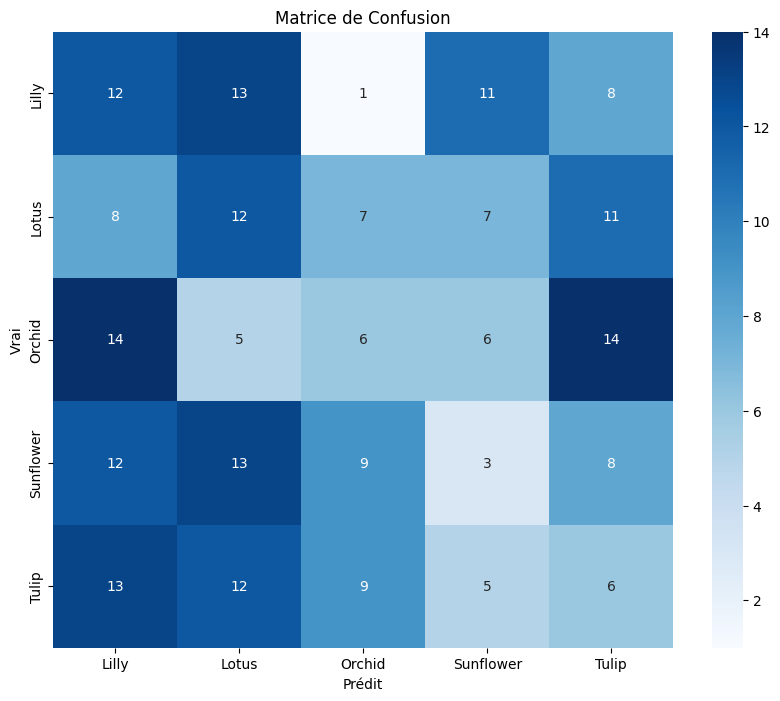

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Génération
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Visualisation
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8082 - loss: 0.5014 - val_accuracy: 0.5867 - val_loss: 1.4408
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8701 - loss: 0.3815 - val_accuracy: 0.6089 - val_loss: 1.4131
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9366 - loss: 0.2144 - val_accuracy: 0.6311 - val_loss: 1.4890
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9341 - loss: 0.1776 - val_accuracy: 0.6222 - val_loss: 1.9209
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9762 - loss: 0.1027 - val_accuracy: 0.6356 - val_loss: 2.2644
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9817 - loss: 0.0818 - val_accuracy: 0.6533 - val_loss: 2.3445
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9950 - loss: 0.0253 - val_accuracy: 0.6533 - val_loss: 2.4593
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9885 - loss: 0.0349 - val_accuracy: 0.6311 - val_loss:

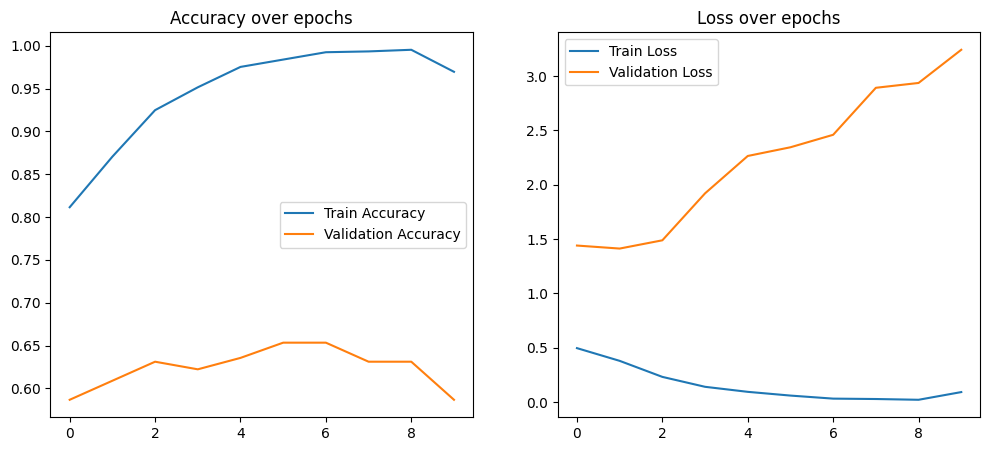

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,

)

# Visualisation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

       Lilly       0.20      0.27      0.23        45
       Lotus       0.22      0.27      0.24        45
      Orchid       0.19      0.13      0.16        45
   Sunflower       0.09      0.07      0.08        45
       Tulip       0.13      0.13      0.13        45

    accuracy                           0.17       225
   macro avg       0.17      0.17      0.17       225
weighted avg       0.17      0.17      0.17       225



In [16]:
import os
import joblib
import tarfile
from datetime import datetime

# 1. Définir le dossier de sauvegarde
MODEL_DIR = r"C:\Users\zhlif\Documents\Intelligence Artificielle\Mise en place\Projet Synthèse\Projet_ML1"
os.makedirs(MODEL_DIR, exist_ok=True)

# 2. Sauvegarde au format .joblib (pour scikit-learn ou Keras via KerasClassifier)
try:
    # Supposons que 'model' est votre modèle entraîné
    joblib.dump(model, os.path.join(MODEL_DIR, "model.joblib"))
    print("Sauvegarde .joblib réussie")
except Exception as e:
    print(f"Erreur lors de la sauvegarde .joblib: {e}")

# 3. Création d'une archive .tar.gz (compression du modèle)
try:
    with tarfile.open(os.path.join(MODEL_DIR, "model.tar.gz"), "w:gz") as tar:
        tar.add(os.path.join(MODEL_DIR, "model.joblib"), arcname="model.joblib")
    print("Compression .tar.gz réussie")
except Exception as e:
    print(f"Erreur lors de la compression .tar.gz: {e}")

Sauvegarde .joblib réussie
Compression .tar.gz réussie


In [ ]:
model.save('/content/Projet Final1/model.h5')